In [0]:
!pip3 install torch torchvision --upgrade
!pip install git+https://github.com/google/sre_yield.git --upgrade

In [0]:
import sre_yield
import random


class generate_data:
  
  def __init__(self, regular_expression):
    
    self.all_examples = list(sre_yield.AllStrings(regular_expression))
    
  def split_data(self, val_size, test_size=None):
    random.shuffle(self.all_examples)
    
    if test_size == None:
      val_size = val_size if val_size < 1 else val_size / 100.0
      split_index = int(len(self.all_examples) * (1-val_size))

      return self.all_examples[:split_index], self.all_examples[split_index:]
    else:
      val_size = val_size if val_size < 1 else val_size / 100.0
      test_size = test_size if val_size < 1 else val_size / 100.0
      split_index_val = int(len(self.all_examples) * (1 - val_size - test_size))
      split_index_test = split_index_val + int(len(self.all_examples) * (1 - test_size))
      
      return self.all_examples[:split_index_val], \
             self.all_examples[split_index_val:split_index_test], \
             self.all_examples[split_index_test:]

In [0]:
import torch

class input_data:
  
  def __init__(self, all_examples, vocab):
    self.all_examples = all_examples
    self.all_examples.sort(key = lambda s: len(s), reverse=True)
    self.max_len_example = len(self.all_examples[0])
    
    self.vocab = vocab  # Arreglo con el vocabulario
    
  def __len__(self):
    return len(self.all_examples)
  
  def __getitem__(self, index):
    sentence_str = self.all_examples[index]
    
    sentence_enc = torch.FloatTensor(torch.zeros((self.max_len_example, len(self.vocab)), dtype=torch.float)) # TODO: LO CAMBIE A FloatTensor en vez de LONG
    
    for idx, char in enumerate(sentence_str):
                                      
      if char not in self.vocab:
        raise ValueError("EL VOCABULARIO NO CONTIENE {}".format(char))

      sentence_enc[idx, self.vocab.index(char)] = 1
    
    target = sentence_str.count("1") # NUMERO DE UNOS QUE TIENE EL STRING
    
#    target = torch.LongTensor([target])
#    target_enc = torch.LongTensor(torch.zeros((self.max_len_example + 1), dtype=torch.long))
#    target_enc[target] = 1
    
    return sentence_enc, target


In [31]:
## TESTING INPUT DATA
regular_expression = "[01]{3,10}"
vocab = ["0", "1"]

data = generate_data(regular_expression=regular_expression)

train_data, val_data = data.split_data(0.2)


dtrain_set = input_data(train_data,
                        vocab = vocab
                        )

print("NUMERO DE EJEMPLOS TRAIN = ", len(dtrain_set))

print("PRIMER EJEMPLO TRAIN = \n", dtrain_set[0][0])

print("PRIMER TARGET TRAIN (Cantidad de unos) = ", dtrain_set[0][1])

dval_set = input_data(val_data,
                      vocab = vocab
                      )

print("NUMERO DE EJEMPLOS VAL = ", len(dval_set))

NUMERO DE EJEMPLOS TRAIN =  1632
PRIMER EJEMPLO TRAIN = 
 tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
PRIMER TARGET TRAIN (Cantidad de unos) =  5
NUMERO DE EJEMPLOS VAL =  408


In [32]:
dtrain_set[0][0].shape

torch.Size([10, 2])

In [33]:
dtrain_set[-1][0]

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable


class RNNClassifier(nn.Module):

    def __init__(self, vocab_size, hidden_dim, num_layers, label_size, batch_size, use_gpu, kind_rnn):
        super(RNNClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        self.kind_rnn = kind_rnn
        self.num_layers = num_layers

        if kind_rnn == "gru":
          self.rnn = nn.GRU(input_size=vocab_size,
                            hidden_size=hidden_dim,
                            num_layers=num_layers
                            )
        elif kind_rnn == "lstm":
          self.rnn = nn.LSTM(input_size=vocab_size,
                             hidden_size=hidden_dim,
                             num_layers=num_layers
                             )
        else:
          raise NotImplementedError

        self.hidden2label = nn.Linear(hidden_dim, label_size)
        
        self.hidden = self.init_hidden()
        
        #self.softmax = nn.Softmax(dim=1)

    def init_hidden(self):
      
        if self.kind_rnn == "gru":
          if self.use_gpu:
            return Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())
          else:
            return Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
          
        elif self.kind_rnn == "lstm":
          if self.use_gpu:
              h0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())
              c0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())
          else:
              h0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
              c0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
          return (h0, c0)
        else:
          raise NotImplementedError

    def forward(self, x):
        # RNN recibe (BATCH_SIZE, NUM_EXAMPLES, HIDDEN_DIM)
        x = torch.transpose(x, 0, 1)
        output, self.hidden = self.rnn(x, self.hidden)
        y  = self.hidden2label(output[-1])
        return y #self.softmax(y)

In [35]:
## TESTING RNNClassifier
vocab_size = 10
batch_size = 3
num_examples = 5

## TESTING GRU

model = RNNClassifier(vocab_size=vocab_size, 
                      hidden_dim=20, 
                      num_layers=2, 
                      label_size=10, 
                      batch_size=batch_size, 
                      use_gpu=torch.cuda.is_available(), 
                      kind_rnn="gru")
model.cuda()

sentence1 = torch.randn(batch_size, num_examples, vocab_size).cuda()
out1 = model(sentence1)

print("OUTPUT GRU = ", out1[-1])

## TESTING LSTM
model = RNNClassifier(vocab_size=vocab_size, 
                      hidden_dim=20, 
                      num_layers=2, 
                      label_size=2, 
                      batch_size=batch_size, 
                      use_gpu=torch.cuda.is_available(), 
                      kind_rnn="lstm")
model.cuda()

sentence2 = torch.randn(batch_size, num_examples, vocab_size).cuda()
out2 = model(sentence1)

print("OUTPUT LSTM = ", out2[-1])

print("OUTPUT GRU 2 = ", model(sentence2)[-1])

OUTPUT GRU =  tensor([-0.1865,  0.3126,  0.0520, -0.1197, -0.1256, -0.3091,  0.0889, -0.0069,
        -0.1137, -0.1839], device='cuda:0', grad_fn=<SelectBackward>)
OUTPUT LSTM =  tensor([-0.1466, -0.1369], device='cuda:0', grad_fn=<SelectBackward>)
OUTPUT GRU 2 =  tensor([-0.1561, -0.0968], device='cuda:0', grad_fn=<SelectBackward>)


In [0]:
# CREO LOS DATA LOADERS

from torch.utils.data import DataLoader

batch_size = 5

train_loader = DataLoader(dtrain_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4
                          )

val_loader = DataLoader(dval_set,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4
                         )

In [0]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [39]:
## TRAIN MODEL 
import torch.nn as nn
import torch.optim as optim

train_loss_ = []
val_loss_   = []
train_acc_  = []
val_acc_    = []

epochs = 30

use_gpu = torch.cuda.is_available()

vocab_size = 2
hidden_dim = 200
num_layers = 1
label_size = 11 # CANTIDAD DE 1s posible [0, 1, ..., max_len]
batch_size = batch_size

learning_rate = 0.01


## USO UNA GRU
model = RNNClassifier(vocab_size=vocab_size, 
                      hidden_dim=hidden_dim, 
                      num_layers=num_layers, 
                      label_size=label_size, 
                      batch_size=batch_size, 
                      use_gpu=use_gpu, 
                      kind_rnn="gru") 


optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

if use_gpu:
  model.cuda()
### training procedure

for epoch in range(epochs):
    ## training epoch
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    
    optimizer = adjust_learning_rate(optimizer, epoch)
    
    for idx, traindata in enumerate(train_loader):
        train_inputs, train_labels = traindata
        train_labels = torch.squeeze(train_labels)
        
        #print(train_inputs.shape)

        if use_gpu:
          train_inputs, train_labels = Variable(train_inputs.cuda()), train_labels.cuda()
        else: 
          train_inputs = Variable(train_inputs)

        model.zero_grad()
        model.batch_size = len(train_labels)
        model.hidden = model.init_hidden()
        output = model(train_inputs) # TODO: LA TRANSPOSICION ESTA EN EL FORWARD (QUIZAS SE DEBA SACAR)
        
        loss = loss_function(output, Variable(train_labels))
        loss.backward()
        optimizer.step()

        # calc training acc
        _, predicted = torch.max(output.data, 1)
        
        #print("PRED", predicted)
        #print("TRUE", train_labels)
        
        total_acc += (predicted == train_labels).sum().item()
        
        total += len(train_labels)
        
        #print("ACC", total_acc)
        #print("TOTAL", total)
        
        total_loss += loss.item()
    
    train_loss_.append(total_loss * 1.0 / total)
    train_acc_.append(total_acc * 1.0 / total)
    
    
    ## val epoch
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    for idx, valdata in enumerate(val_loader):
        val_inputs, val_labels = valdata
        val_labels = torch.squeeze(val_labels)

        if use_gpu:
          val_inputs, val_labels = Variable(val_inputs.cuda()), val_labels.cuda()
        else: 
          val_inputs = Variable(val_inputs)

        model.batch_size = len(val_labels)
        model.hidden = model.init_hidden()
        output = model(val_inputs) # TODO: LA TRANSPOSICION ESTA EN EL FORWARD (QUIZAS SE DEBA SACAR)

        loss = loss_function(output, Variable(val_labels))

        # calc val acc
        _, predicted = torch.max(output.data, 1)
        
        
        total_acc += (predicted == val_labels).sum().item()
        total += len(val_labels)
        total_loss += loss.item()
    val_loss_.append(total_loss * 1.0  / total)
    val_acc_.append(total_acc * 1.0 / total)

    print('[Epoch: %3d/%3d] Training Loss: %.3f, Val Loss: %.3f, Training Acc: %.3f, Val Acc: %.3f'
          % (epoch, epochs, train_loss_[epoch], val_loss_[epoch], train_acc_[epoch], val_acc_[epoch]))


[Epoch:   0/ 30] Training Loss: 0.440, Val Loss: 0.407, Training Acc: 0.222, Val Acc: 0.230
[Epoch:   1/ 30] Training Loss: 0.395, Val Loss: 0.384, Training Acc: 0.233, Val Acc: 0.230
[Epoch:   2/ 30] Training Loss: 0.384, Val Loss: 0.378, Training Acc: 0.240, Val Acc: 0.265
[Epoch:   3/ 30] Training Loss: 0.379, Val Loss: 0.374, Training Acc: 0.238, Val Acc: 0.314
[Epoch:   4/ 30] Training Loss: 0.374, Val Loss: 0.368, Training Acc: 0.252, Val Acc: 0.270
[Epoch:   5/ 30] Training Loss: 0.365, Val Loss: 0.357, Training Acc: 0.281, Val Acc: 0.289
[Epoch:   6/ 30] Training Loss: 0.347, Val Loss: 0.327, Training Acc: 0.325, Val Acc: 0.343
[Epoch:   7/ 30] Training Loss: 0.293, Val Loss: 0.269, Training Acc: 0.523, Val Acc: 0.525
[Epoch:   8/ 30] Training Loss: 0.252, Val Loss: 0.245, Training Acc: 0.550, Val Acc: 0.547
[Epoch:   9/ 30] Training Loss: 0.231, Val Loss: 0.226, Training Acc: 0.592, Val Acc: 0.627
[Epoch:  10/ 30] Training Loss: 0.218, Val Loss: 0.221, Training Acc: 0.646, Val

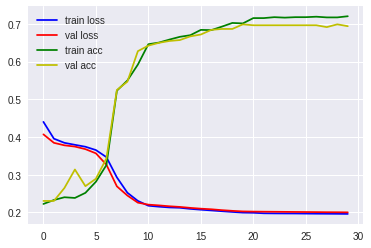

In [40]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


plt.plot(range(0, epochs), train_loss_, c='b')
plt.plot(range(0, epochs), val_loss_, c='r')
plt.plot(range(0, epochs), train_acc_, c='g')
plt.plot(range(0, epochs), val_acc_, c='y')
plt.legend(["train loss", "val loss", "train acc", "val acc"])